# General Settings:

Directory Data:

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from datetime import datetime


import ribo_util
import ribo_main
import ribo_analysis
import ribo_plot
import ribo_coords

import os

# File names can be manually added to list, or read as .csv with header == Library
# Library names must be the same as the fastq file name

path_pc     = '/home/gyrase/datatank/Bikmetov/toxin_profiling/2018_Bacterial_Pipeline_riboseq-clean_first/results/'  # location of folder for ribosome profiling
path_script = '/home/gyrase/datatank/Bikmetov/toxin_profiling/2018_Bacterial_Pipeline_riboseq-clean_first/'

all_files  = [x for x in os.listdir(path_pc + '/libraries/FASTQ/')]
file_csv   = path_script  + 'Library_names.csv'  # alternatively, provide .csv with filenames
'''
all_files  = []                              # sample name, same as FASTQ filename
file_csv   = path_pc  + 'Library_names.csv'  # alternatively, provide .csv with filenames

library_id = pd.read_csv(file_csv)

for fname in library_id.Library:
    all_files.append(fname)'''
print all_files

inputs = {}
inputs['files'] = []
inputs['multiprocess'] = 'yes'
inputs['threads']      = 20   # CPU information for multithreading applications
inputs['cores']        = 10

paths_in = {}
paths_in['path_gff']        = path_pc + 'annotations/Coli/Coli.gff'
paths_in['path_gff_dict']   = path_pc + 'annotations/Coli/Coli_dict'       # this will be made from the GFF file
paths_in['path_badgenes']   = path_pc + 'annotations/Coli/bad_genes.csv'   # list of genes to exclude
paths_in['path_annotation'] = path_pc + 'annotations/Coli/annotation.csv'  # adds gene description to GFF_dict 

# Outputs from analysis will be placed in the foillowing directories:
paths_out = {}
paths_out['path_density']      = path_pc  + 'libraries/density/density/'  # Created from Ribo_Density
paths_out['path_log']          = path_pc  + 'libraries/density/logs/'
paths_out['path_analysis_log'] = path_pc  + 'libraries/analysis/logs/'
paths_out['path_analysis']     = path_pc  + 'libraries/analysis/individual/'
paths_out['path_figures']      = path_pc  + 'libraries/figures/'

    
# Check inputs, create output paths
step = 'analysis'                                # density or analysis
ribo_util.check_inputs(inputs, paths_in, step)   # will remove file from analysis for not having a density file
ribo_util.createpath(inputs, paths_out, all_files)          # create output paths


['T62.filter.fastq', 'TacT3.filter.fastq', 'Ita3.filter.fastq', 'Control.filter.fastq']


# Analysis Settings

Set settings values for the various analyses

In [20]:
# General Settings 
settings = {}
settings['minlength'] = 15    # minimum read lenght
settings['maxlength'] = 40    # maximum read length
settings['shift']     = 11    # A-site shift
settings['gff_extra'] = 50    # Number of nt added before start seq and after stop seq in GFF_dict
settings['threshold'] = 1    # in reads per codon
settings['alignment'] = '3'   # '3' or '5'

# Avggenes Settings
settings['length_out_ORF'] = 50
settings['length_in_ORF']  = 100        # genes shorter than this are excluded
settings['density_type']   = 'reads'    # 'reads' or 'rpm' 
settings['equal_weight']   = 'yes'      # 'yes' or 'no', if yes, change density_type to reads -- faster
settings['next_gene']      = 25         # genes closer than this are removed from start and stop 

# Pausescore settings
settings['A_site shift']    = -11
settings['plot_upstream']   = 40
settings['plot_downstream'] = 50
settings['start_trim']      = 50
settings['stop_trim']       = 20
settings['frameshift']      = 0

# Genelist settings
settings['subgroup'] = 'none'

# Pausescore waves settings
settings['plot_upstream_wave']   = 106
settings['plot_downstream_wave'] = 106
settings['next_codon']           = 'yes'

# Motif analysis
settings['motif_length'] = 9


# Create Annotation dictionary from GFF

Pipeline uses a simplified dictionary of the GFF for speed. This function will strip the GFF to the gene name, start and stop position, and sequence of the gene

This needs to be run only once, so you can comment it off once it does run


In [21]:
gff_settings = {}
gff_settings['path_out']         = 0             # set to 0 to output in annotations folder
gff_settings['feat_of_interest'] = 'all'         # all, CDS, tRNA, rRNA: recommend using all
gff_settings['name_qual']        = 'Name'        # GFF gene qualifier
gff_settings['name_qual_alt']    = 'ID'          # Secondary GFF gene qualifier if no name is present
gff_settings['remove_genes']     = 'yes'         # remove hard to align genes listed in bad_genes.csv
gff_settings['gff_extra']         = 50           # additional sequence upstream and downstream of gene (set to 50)

#GFF_conversion = ribo_util.GFF_to_dict(paths_in, gff_settings)


In [22]:
lib_count = len(all_files)
lib_index = 0 
lib_runs  = 8  # limits number of samples processed, scale with RAM imitations

for loops in range(0, lib_count / lib_runs + 2):

    if lib_index < lib_count:
        print "Started  at " + str(datetime.now())
        if lib_count - lib_index >= lib_runs:
            inputs['files'] = [all_files[i] for i in range(lib_index, lib_index + lib_runs)]

            print inputs['files']
            
            if not 'gff_dict' in globals(): 
                gff_dict, plus_dict, minus_dict = ribo_util.loadlargePickles(inputs, settings, paths_in, paths_out)
            else: 
                gff_dict, plus_dict, minus_dict = ribo_util.loadlargePickles(inputs, settings, paths_in, paths_out)
            
            #average_gene = ribo_analysis.avggenes(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            #pausescore_analysis = ribo_analysis.pausescore(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            #genelists = ribo_analysis.genelist(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            asymmetry_analysis = ribo_coords.asymmetry(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            #frame_analysis     = ribo_analysis.frame(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            #wave_analysis = ribo_analysis.pausescore_waves(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            #motif_analysis = ribo_analysis.motif_pausescore(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            
        else:
            inputs['files'] = [all_files[i] for i in range(lib_index, lib_count)]
            
            print inputs['files']    
            if not 'gff_dict' in globals(): 
                gff_dict, plus_dict, minus_dict = ribo_util.loadlargePickles(inputs, settings, paths_in, paths_out)
            else: 
                gff_dict, plus_dict, minus_dict = ribo_util.loadlargePickles(inputs, settings, paths_in, paths_out)
                
            #average_gene = ribo_analysis.avggenes(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            #pausescore_analysis = ribo_analysis.pausescore(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            #genelists = ribo_analysis.genelist(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            asymmetry_analysis = ribo_coords.asymmetry(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            #frame_analysis     = ribo_analysis.frame(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            #wave_analysis = ribo_analysis.pausescore_waves(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            #motif_analysis = ribo_analysis.motif_pausescore(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)

    else:
        continue
    lib_index += lib_runs  
print "Finished  at " + str(datetime.now())

Started  at 2020-01-24 16:15:16.842248
['T62.filter.fastq', 'TacT3.filter.fastq', 'Ita3.filter.fastq', 'Control.filter.fastq']
Started asymmetry analysis at 2020-01-24 16:17:32.802675
42360136.0
[7115274. 7029851. 5286136. 4618415. 3651400. 3253557. 3293794. 2854008.
 2803412. 2454289.]
13150128.0
[3405642. 2448826. 1679751. 1300325.  888547.  795895.  795856.  640197.
  600110.  594979.]
5071904.0
[913542. 759410. 666052. 535856. 451255. 395622. 392254. 361796. 338128.
 257989.]
16846500.0
[2278037. 1905547. 1778740. 1653611. 1502624. 1618224. 1560043. 1551383.
 1499831. 1498460.]
Finished asymmetry analysis at 2020-01-24 16:17:42.130581
Finished  at 2020-01-24 16:17:42.131013


In [1]:
import pickle

In [24]:
with open('results/libraries/analysis/individual/Ita3.filter.fastq/asymmetry_per_cent', 'r') as inf:
    Ita3 = pickle.load(inf)
Ita3

array([18.01181568, 14.97287804, 13.13218862, 10.5651842 ,  8.89715184,
        7.80026594,  7.73386089,  7.13333691,  6.6666877 ,  5.08663019])

In [25]:
per_cent = {}
for x in all_files:
    with open('results/libraries/analysis/individual/' + x + '/asymmetry_per_cent_solo', 'r') as inf:
        df = pd.DataFrame.from_dict(pickle.load(inf)).T
        res = df.sum() * 100 / df.sum().sum()
        per_cent[x.split('.')[0]] = res
per_cent['Per cent'] = np.array(['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100'])
per_cent

{'Control': array([13.52231621, 11.31123379, 10.55851364,  9.81575401,  8.91950257,
         9.60569851,  9.26033894,  9.20893361,  8.90292346,  8.89478527]),
 'Ita3': array([18.01181568, 14.97287804, 13.13218862, 10.5651842 ,  8.89715184,
         7.80026594,  7.73386089,  7.13333691,  6.6666877 ,  5.08663019]),
 'Per cent': array(['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70',
        '70-80', '80-90', '90-100'], dtype='|S6'),
 'T62': array([16.79709905, 16.59544011, 12.47903453, 10.90273884,  8.61989678,
         7.6807048 ,  7.77569269,  6.73748545,  6.61804296,  5.79386478]),
 'TacT3': array([25.89816616, 18.62206969, 12.77364753,  9.88830679,  6.75694564,
         6.05237455,  6.05207797,  4.86837086,  4.56352972,  4.52451109])}

In [26]:
df = pd.DataFrame.from_dict(per_cent).set_index('Per cent')

In [27]:
df

,Control,Ita3,T62,TacT3
Per cent,,,,
0-10,13.522316,18.011816,16.797099,25.898166
10-20,11.311234,14.972878,16.595440,18.622070
20-30,10.558514,13.132189,12.479035,12.773648
30-40,9.815754,10.565184,10.902739,9.888307
40-50,8.919503,8.897152,8.619897,6.756946
50-60,9.605699,7.800266,7.680705,6.052375
60-70,9.260339,7.733861,7.775693,6.052078
70-80,9.208934,7.133337,6.737485,4.868371
80-90,8.902923,6.666688,6.618043,4.563530


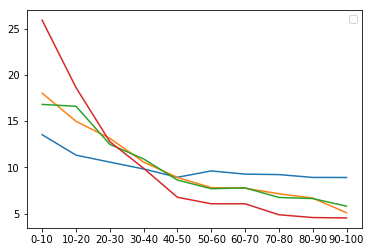

In [28]:
import matplotlib.pylab as plt
%matplotlib inline
plt.plot(df)
plt.legend()
plt.show()

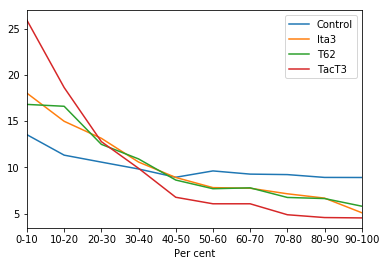

In [29]:
df.plot()

In [34]:
df.to_excel('per_cent.xlsx')

In [32]:
df2 = df.copy()
with pd.ExcelWriter('per_cent.xlsx') as writer:  # doctest: +SKIP
    df1.to_excel(writer, sheet_name='per_cent')

ImportError: No module named openpyxl.workbook